In [177]:
import itertools

import numpy as np
import numpy.ma as ma

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



## 2.1

In [2]:
# download the full dataset
newsgroups = fetch_20newsgroups(subset='all')

In [3]:
# change text to tfidf vector representation
vectorizer = TfidfVectorizer()
data_tfidf = vectorizer.fit_transform(newsgroups.data)

In [4]:
# feature matrix X, target labels y
X,y = data_tfidf,newsgroups.target

In [5]:
# take 80% for training
X_train, X_testval, y_train, y_testval = train_test_split(X ,y , test_size=0.2, random_state=42)

In [6]:
# 10% for test, 10% for validation
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, test_size=5, random_state=42)

## 2.2

In general, the more trees you use the better get the results. However, the improvement decreases as the number of trees increases, i.e. at a certain point the benefit in prediction performance from learning more trees will be lower than the cost in computation time for learning these additional trees. For this reason we decide to follow the distribution use in this [paper](https://www.researchgate.net/publication/230766603_How_Many_Trees_in_a_Random_Forest) (section 7, table 3) mentionned in Mattermost, and to limit the number of trees to a few hundreds.

Also, instead of splitting ourselves the dataset into train/validation/test sets and using using the validation set to tune the parameters, we use the build-in cross validation scoring function of GridsearchCV.
This, we have 80% on train set and 20% on test set.
The cross validation splits the data, trains on one part and validates on the other which is comparable to split and tune with a validation set. Cross-validation repeats the procedure dependings on the number of folds. Common number of folds are 5 and 10 depending on the size of the dataset. For computational reason, we will only do 3 folds.

### Random forest parameter tuning

In [117]:
# random forest
clf = RandomForestClassifier()

# values for parameters we want to check in the grid search
param_grid = {"max_depth": np.arange(75,106,10),
             "n_estimators": np.power(2, np.arange(10))} # 2,4,8,16...512

# n_jobs=-1 to use all the processor cores
# cv = 3, that's the number of folds
gs_clf = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, cv=3)

In [ ]:
# launch grid search on the training data
gs_clf = gs_clf.fit(X_train, y_train)

In [119]:
# print the best score and parameters
print("best score: %r" % gs_clf.best_score_)
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

best score: 0.84518439904483944
max_depth: 95
n_estimators: 512


We now plot the scores on a 3D surface.

In [136]:
results = gs_clf.cv_results_
depths = ma.getdata(results['param_max_depth']).reshape(4,-1)
trees = ma.getdata(results['param_n_estimators']).reshape(4,-1)
scores = results['mean_test_score'].reshape(4,-1)

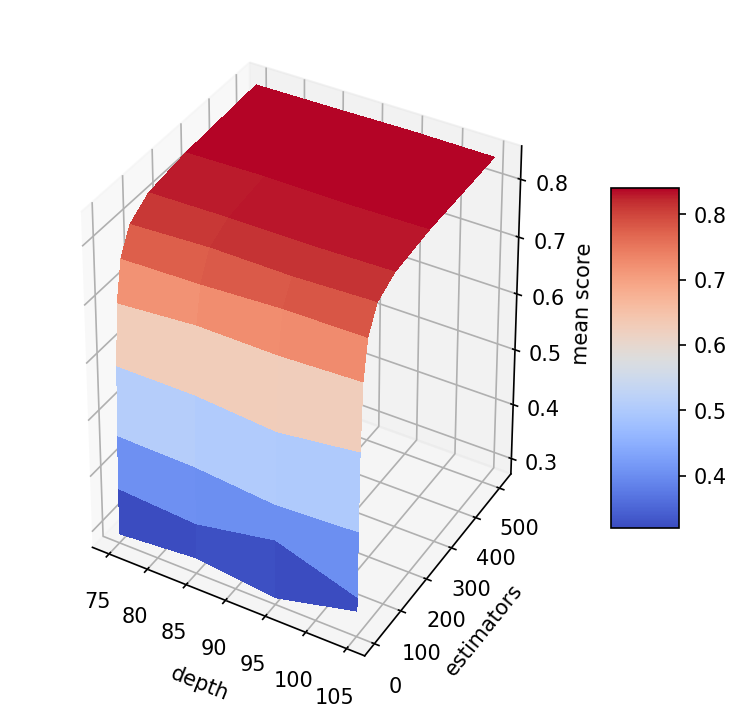

In [141]:
fig = plt.figure(figsize=(6,6), dpi=150)
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(depths, trees, scores, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('depth')
ax.set_ylabel('estimators')
ax.set_zlabel('mean score')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

The plot clearly shows that the depths doesn't help a lot for the score. The best depth is around 95.
It's really the number of estimators that changes the scoring result. After 256 the gain gets really low and is not worth the added computational time.

Below we can trained the random forst with depth 95 and n_estimators 512,256,128,64 and we can see that indeed the score doesn't get a lot better after 256 and even 128 is already good. 

In [130]:
clf_512 = RandomForestClassifier(max_depth=95, n_estimators=512)
clf_512.fit(X_train,y_train)
clf_512.score(X_testval, y_testval)

0.85543766578249336

In [131]:
clf_256 = RandomForestClassifier(max_depth=95, n_estimators=256)
clf_256.fit(X_train,y_train)
clf_256.score(X_testval, y_testval)

0.85305039787798409

In [132]:
clf_128 = RandomForestClassifier(max_depth=95, n_estimators=128)
clf_128.fit(X_train,y_train)
clf_128.score(X_testval, y_testval)

0.84482758620689657

In [133]:
clf_64 = RandomForestClassifier(max_depth=95, n_estimators=64)
clf_64.fit(X_train,y_train)
clf_64.score(X_testval, y_testval)

0.8214854111405836

### Confusion matrix

In the confusion matrix each row of the matrix represents the instances with the actual labels while each column represents the predicted labels. We generate it with by predicting the values of the test set.

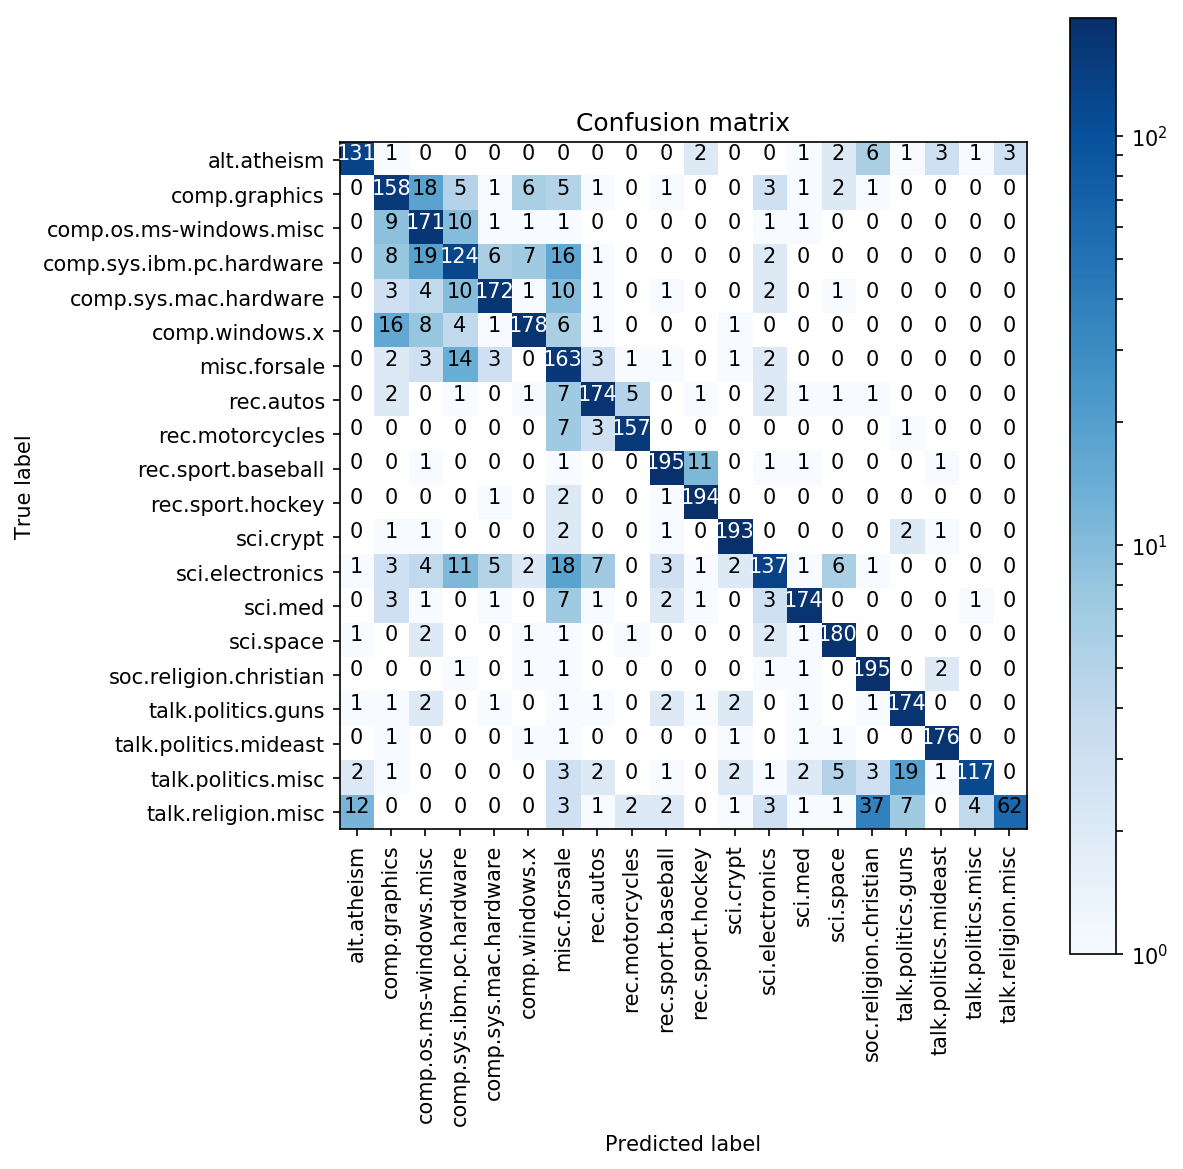

In [171]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix'):


    plt.imshow(cm, interpolation='nearest', norm=matplotlib.colors.LogNorm(), cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# confusion matrix for the best estimator on the testing set
y_pred = clf_512.predict(X_testval)
cnf_matrix = confusion_matrix(y_testval, y_pred)

plt.figure(figsize=(8,8), dpi=150)
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names, title='Confusion matrix')
plt.show()

The diagonal values are the one that were right. The labels [comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, ocmp.sys.mac.hardware, comp.windows.x, misc.forsale] are a bit mixed up and most of the classifier errors are in those labels. The sci-eletronics has some false negative. 

### important features

We first plot the histogram of the feature_importances. We see that the distribution is heavy-tailed and that most of the values are in the first bin.

In [ ]:
feature_importance = gs_clf.best_estimator_.feature_importances_

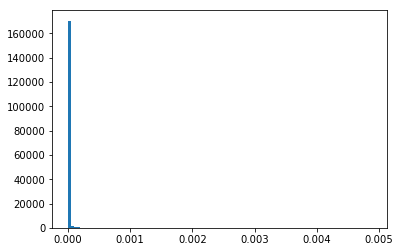

In [176]:
plt.hist(feature_importance, bins=100)
plt.show()

Then we show the same histogram but with a log y axis.

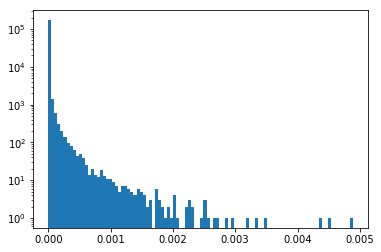

In [175]:
n_per_bin,_,_ = plt.hist(feature_importance, bins=100)
plt.gca().set_yscale("log")
plt.show()

In [166]:
[int(x) for x in n_per_bin]

[173639, 95, 21, 4, 3]

 We can still see that most of the features (160000 +) have a very low importance. Therfore, we could probably get rid of some of them. A good start would be to train the classifier with the top features and see the result and then, depending on the difference on the result with the model trained on the full dataset, try to add more features. Usually we take put a threshold using the mean of the median.

In [159]:
sfm = SelectFromModel(clf_256, threshold=0.1*feature_importance.mean())
sfm.fit(X_train,y_train)
X_new_train = sfm.transform(X_train)
X_new_testval = sfm.transform(X_testval)

In [169]:
print(X_train.shape)
print(X_new_train.shape)

(15076, 173762)
(15076, 51394)


In [158]:
clf_256_new = RandomForestClassifier(max_depth=90, n_estimators=256)
clf_256_new.fit(X_new_train,y_train)
clf_256_new.score(X_new_testval, y_testval)

0.8392572944297082

We can see that putting a threshold to 0.1 * mean we get ~0.839 with 51'394 instead of ~0.853 with all the features (173'639). The results are close using roughly a third of the features. This can be further optimise but we already see that  we can save computational spending with this method. 